# **Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 808kB 16.6MB/s 
     |████████████████████████████████| 8.7MB 18.6MB/s 
     |████████████████████████████████| 2.1MB 32.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [3]:
#!pip install chart_studio

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, arima

In [5]:
!pip install transformers

     |████████████████████████████████| 1.4MB 4.2MB/s 
     |████████████████████████████████| 2.9MB 31.4MB/s 
     |████████████████████████████████| 890kB 29.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8fb549b94b6621a8f4c522b7ff15c747c308bec0e456876017e06421044e5027
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import torch.utils.data as tdata
import torch.optim as optim

import tqdm

torch.manual_seed(0)
np.random.seed(0)

# **Data Prep**

In [7]:
data = pd.read_csv('/content/drive/My Drive/Time_Series/Faturamento_Real_Industria.csv', sep=',', quotechar='"', decimal=',')

In [8]:
data.columns

Index(['Data',
       'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12',
       'Unnamed: 2'],
      dtype='object')

In [9]:
data = data.drop(['Unnamed: 2'], axis=1)

In [10]:
data.columns

Index(['Data', 'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12'], dtype='object')

In [11]:
new_column_names = ['date', 'value']

In [12]:
{c:new_c for c, new_c in zip(data.columns, new_column_names)}

{'Data': 'date',
 'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12': 'value'}

In [13]:
data = data.rename(columns={c:new_c for c, new_c in zip(data.columns, new_column_names)})

In [14]:
data

,date,value
0,1991.12,48.9298103406456
1,1992.01,51.4594452614013
2,1992.02,51.69044906082
3,1992.03,54.1242662496314
4,1992.04,55.7037379103317
...,...,...
341,2020.05,84.5
342,2020.06,96.5
343,2020.07,109.6
344,2020.08,112


In [15]:
data.dtypes

date     object
value    object
dtype: object

In [16]:
data['value'] = data['value'].astype(np.float64)
data['month'] = data['date'].apply(lambda x: int(str(x)[-2:]))
data['year'] = data['date'].apply(lambda x: int(str(x)[:4]))

In [17]:
data

,date,value,month,year
0,1991.12,48.929810,12,1991
1,1992.01,51.459445,1,1992
2,1992.02,51.690449,2,1992
3,1992.03,54.124266,3,1992
4,1992.04,55.703738,4,1992
...,...,...,...,...
341,2020.05,84.500000,5,2020
342,2020.06,96.500000,6,2020
343,2020.07,109.600000,7,2020
344,2020.08,112.000000,8,2020


## **Series Truncation**

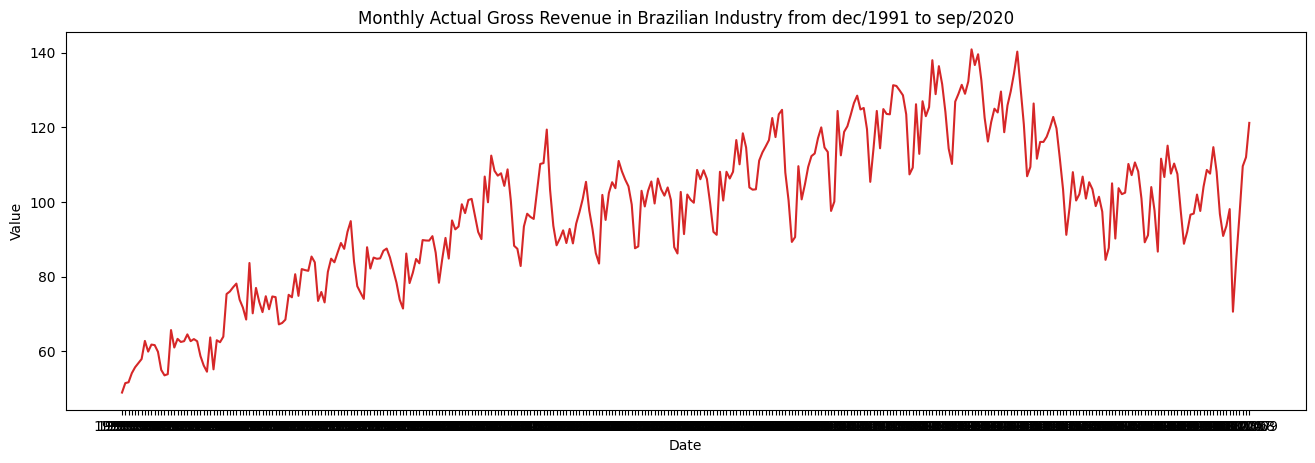

In [18]:
x = data.date
xlabel='Date'
y = data.value
ylabel='Value'
title='Monthly Actual Gross Revenue in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

In [19]:
data = data[data['date'] >= '2005.01'].reset_index()

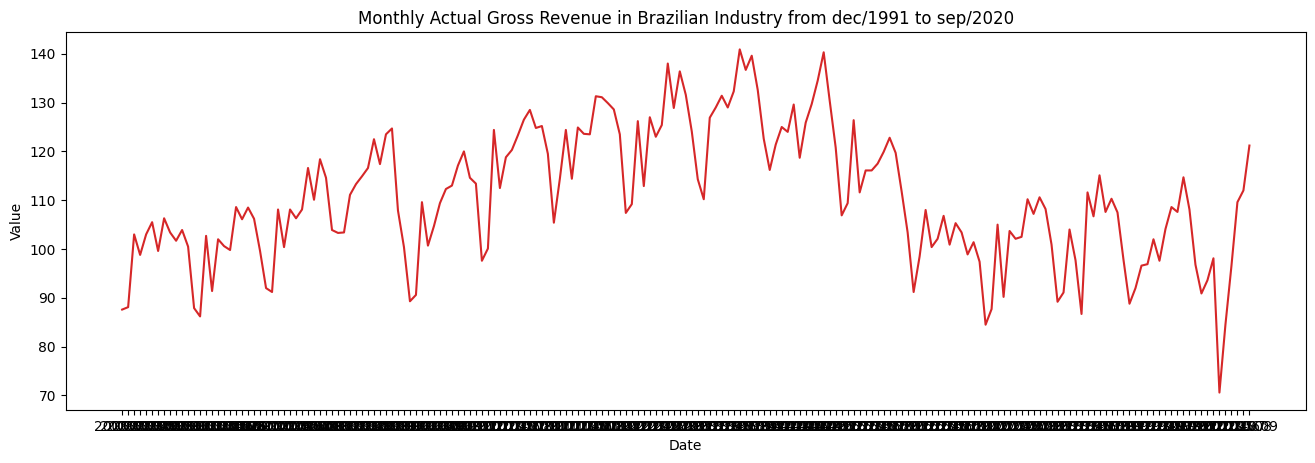

In [20]:
x = data.date
xlabel='Date'
y = data.value
ylabel='Value'
title='Monthly Actual Gross Revenue in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

In [21]:
data.dtypes

index      int64
date      object
value    float64
month      int64
year       int64
dtype: object

## **Exogenous Feature Engineering**

In [22]:
data['brazilian_economic_recession'] = data['date'].apply(lambda x: 1 if x >= '2015.01' and x <= '2016.12' else 0) 

In [23]:
data['pandemy_fall'] = data['date'].apply(lambda x: 1 if x == '2020.04' else 0) 

In [24]:
data['month_Jan'] = data['month'].apply(lambda x: 1 if x == 1 else 0)
data['month_Feb'] = data['month'].apply(lambda x: 1 if x == 2 else 0)
data['month_Mar'] = data['month'].apply(lambda x: 1 if x == 3 else 0)
data['month_Apr'] = data['month'].apply(lambda x: 1 if x == 4 else 0)
data['month_May'] = data['month'].apply(lambda x: 1 if x == 5 else 0)
data['month_Jun'] = data['month'].apply(lambda x: 1 if x == 6 else 0)
#data['month_Jul'] = data['month'].apply(lambda x: 1 if x == 7 else 0) # reference class
data['month_Aug'] = data['month'].apply(lambda x: 1 if x == 8 else 0)
data['month_Sep'] = data['month'].apply(lambda x: 1 if x == 9 else 0)
data['month_Oct'] = data['month'].apply(lambda x: 1 if x == 10 else 0)
data['month_Nov'] = data['month'].apply(lambda x: 1 if x == 11 else 0)
data['month_Dec'] = data['month'].apply(lambda x: 1 if x == 12 else 0)

In [25]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0


## **Stationarity Evaluation**

In [26]:
# ADF Test
print('Time Series Stationary Test')
result = adfuller(data.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
print('Trend Stationary Test')
result = kpss(data.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Time Series Stationary Test
ADF Statistic: -1.8144698921610918
p-value: 0.37330182540375983
Critial Values:
   1%, -3.4685016947910636
Critial Values:
   5%, -2.8782983668563396
Critial Values:
   10%, -2.57570415906989
Trend Stationary Test

KPSS Statistic: 0.286053
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### **1st and 2nd Order of Differentiation**

In [27]:
data['value_diff1'] = data['value'].diff()
data['value_diff2'] = data['value_diff1'].diff()

In [28]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,value_diff1,value_diff2
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0,0.5,NaN
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0,14.9,14.4
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0,-4.2,-19.1
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0,4.2,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,13.9,41.4
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,-1.9
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,13.1,1.1
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0,2.4,-10.7


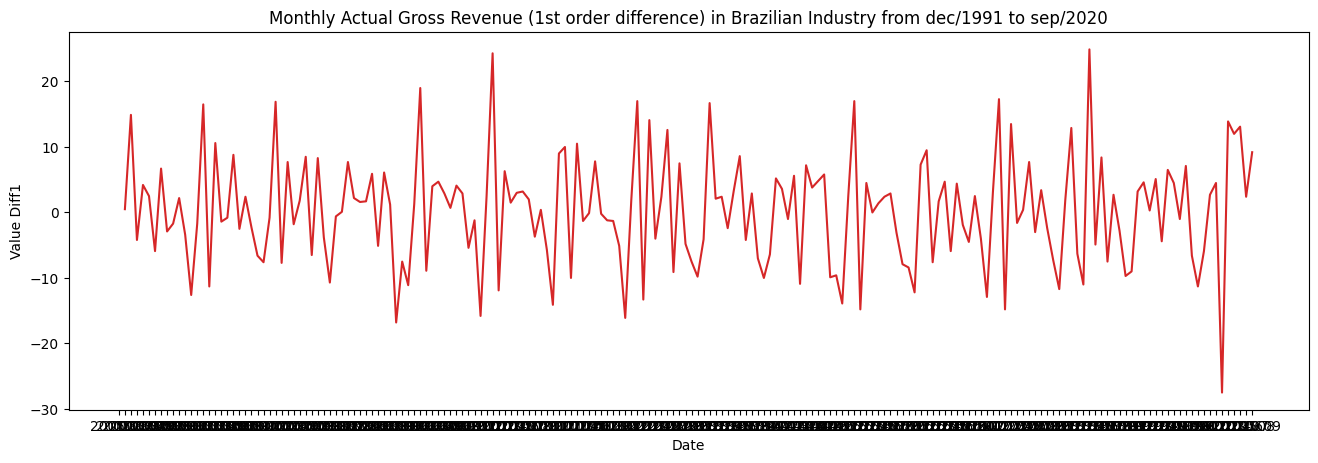

In [29]:
x = data.date
xlabel='Date'
y = data.value_diff1
ylabel='Value Diff1'
title='Monthly Actual Gross Revenue (1st order difference) in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

In [30]:
# ADF Test
print('Time Series Stationary Test')
result = adfuller(data.value_diff1.values[1:], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
print('Trend Stationary Test')
result = kpss(data.value_diff1.values[1:], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Time Series Stationary Test
ADF Statistic: -2.913024542672198
p-value: 0.04385424894082136
Critial Values:
   1%, -3.4685016947910636
Critial Values:
   5%, -2.8782983668563396
Critial Values:
   10%, -2.57570415906989
Trend Stationary Test

KPSS Statistic: 0.104320
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [31]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,value_diff1,value_diff2
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0,0.5,NaN
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0,14.9,14.4
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0,-4.2,-19.1
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0,4.2,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,13.9,41.4
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,-1.9
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,13.1,1.1
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0,2.4,-10.7


# **Exploratory Data Analysis**

## **Trend e Seasonality Analysis**

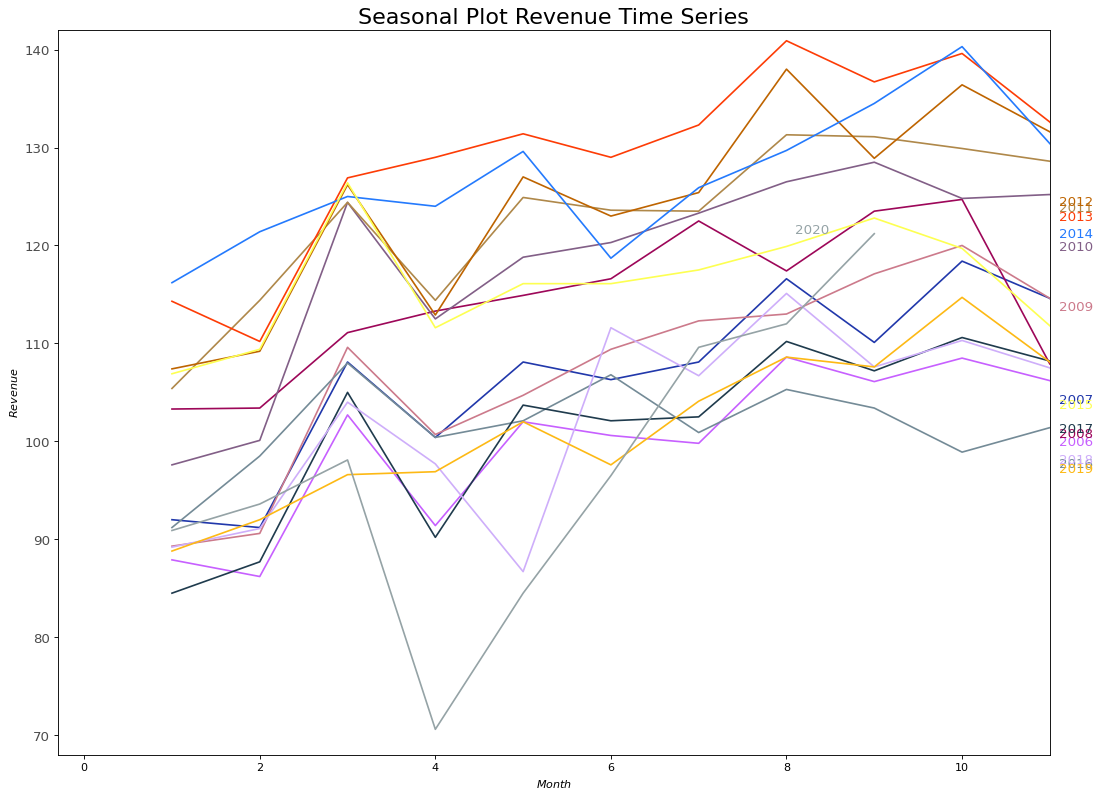

In [32]:
##Seasonal Plot of a Time Series

# Prepare data
years = data['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=data.loc[data.year==y, :], color=mycolors[i], label=y)
        plt.text(data.loc[data.year==y, :].shape[0]-.9, data.loc[data.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(68, 142), ylabel='$Revenue$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot Revenue Time Series", fontsize=20)
plt.show()

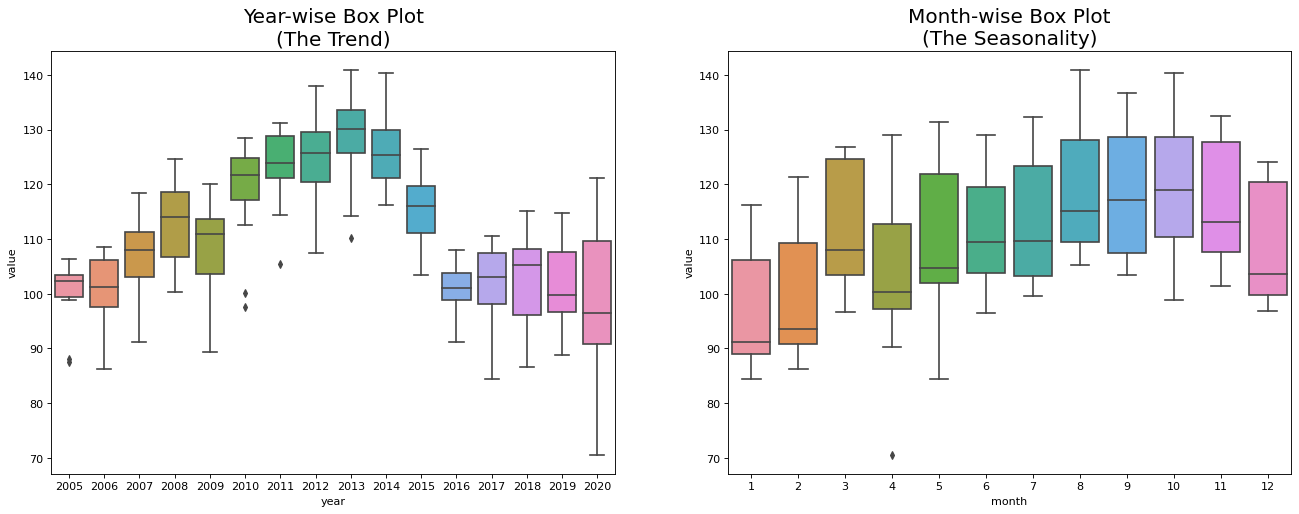

In [33]:
##Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=data, ax=axes[0])
sns.boxplot(x='month', y='value', data=data.loc[~data.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()


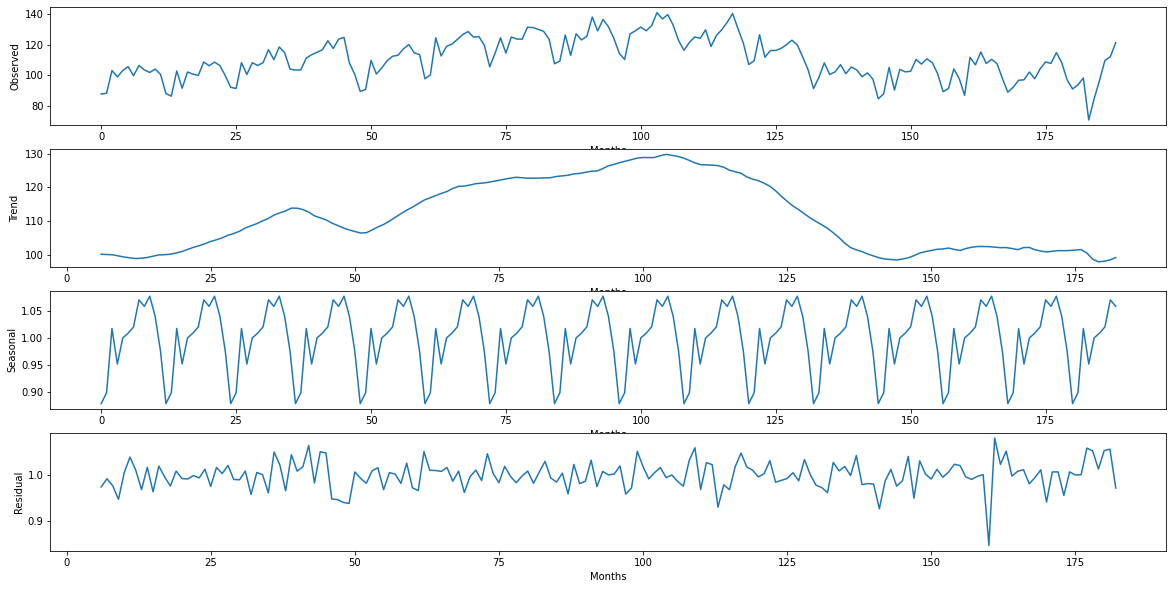

In [34]:
result = seasonal_decompose(data.value.values, model='multiplicative', period = 12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,10))
ax1.set(xlabel='Months', ylabel='Observed')
ax1.plot(result.observed)
ax2.set(xlabel='Months', ylabel='Trend')
ax2.plot(result.trend)
ax3.set(xlabel='Months', ylabel='Seasonal')
ax3.plot(result.seasonal)
ax4.set(xlabel='Months', ylabel='Residual')
ax4.plot(result.resid)

# **Data Partition**

In [35]:
data_train = data[:-int(round(len(data) * 0.2))]
data_test = data[-int(round(len(data) * 0.2)):]

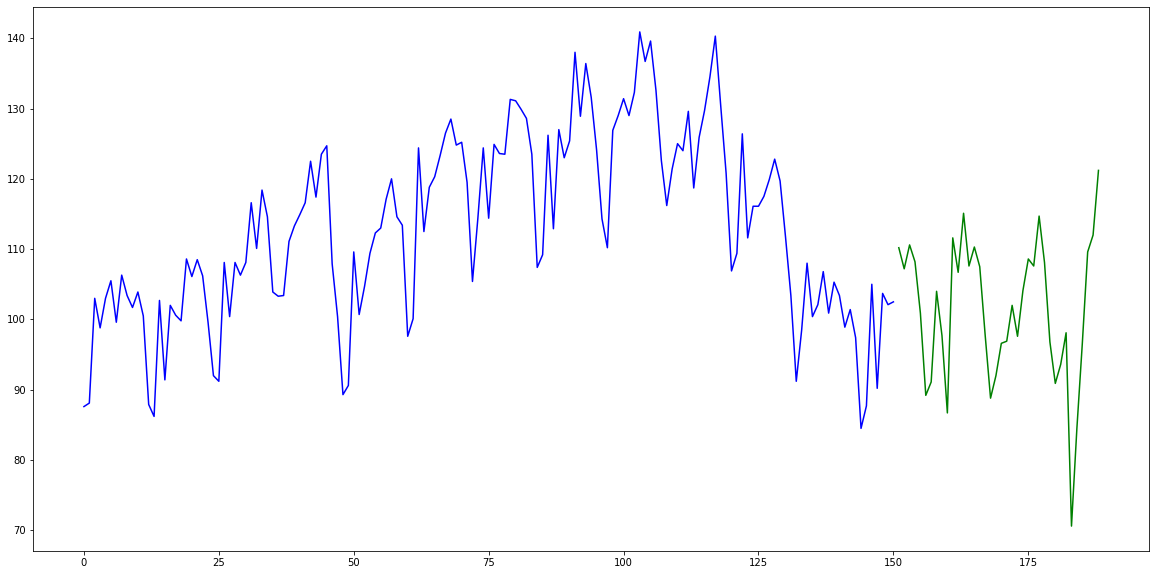

In [36]:
plt.figure(figsize=(20,10))
plt.plot(data_train.index.values, data_train.value.values, 'b') # plotting t, b separately 
plt.plot(data_test.index.values, data_test.value.values, 'g') # plotting t, c separately 
plt.show()

# **Modelling**

## **Model 1 - SARIMAX**

### **Order Identification**

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


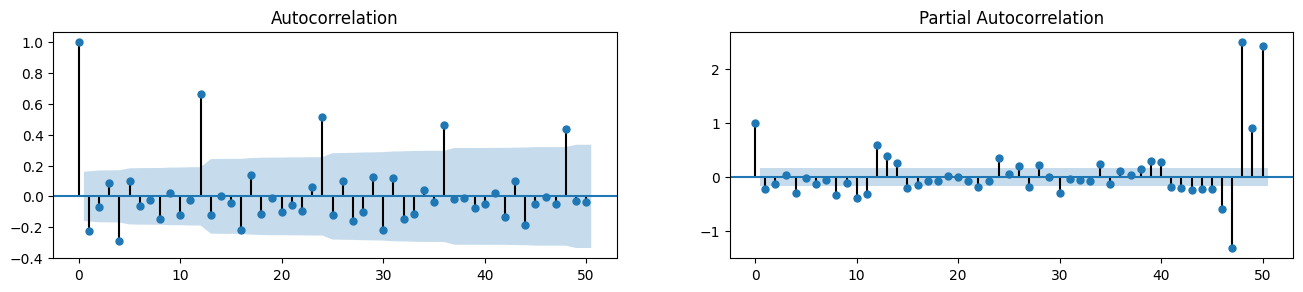

In [37]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_train.value_diff1[1:].tolist(), lags=50, ax=axes[0])
plot_pacf(data_train.value_diff1[1:].tolist(), lags=50, ax=axes[1])
plt.show()

### **Testing SARIMA with vs without intercept**

In [38]:
model_with_intercept_diff1 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=True)
model_with_intercept_diff1_fit = model_with_intercept_diff1.fit(data_train.value)
model_with_intercept_diff1_fit.aic()

789.1431771120085

In [39]:
model_with_intercept_diff1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -372.572
Date:                               Wed, 02 Dec 2020   AIC                            789.143
Time:                                       21:21:07   BIC                            853.543
Sample:                                            0   HQIC                           815.314
                                               - 151                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2786      0.229     -1.216      0.224      -0.728       0.170
ar.L1         -0.0592      0.547     -0.108      0.914      -1.132       1.013
ar.L2          0.6069      0.397      1.527      0.127      -0.172       1.386
ar.L3         -0.3502      0.229     -1.530      0.126      -0.799       0.098
ar.L4         -0.6129      0.366     -1.676      0.094      -1.329       0.104
ma.L1         -0.3445      0.553     -0.623      0.534      -1.429       0.740
ma.L2         -0.6405      0.621     -1.032      0.302      -1.857       0.576
ma.L3          0.8198      0.193      4.242      0.000       0.441       1.199
ma.L4          0.2418      0.568      0.426      0.670      -0.870       1.354
ma.L5         -0.2183      0.404     -0.540      0.589      -1.011       0.574
ma.L6          0.3038      0.240      1.266      0.205      -0.166       0.774
ma.L7         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L8         -0.1338      0.341     -0.393      0.694      -0.801       0.534
ma.L9          0.4473      0.200      2.238      0.025       0.056       0.839
ma.L10        -0.1737      0.209     -0.832      0.405      -0.583       0.235
ma.L11        -0.1681      0.286     -0.588      0.557      -0.729       0.393
ar.S.L12      -0.1577      0.152     -1.038      0.299      -0.455       0.140
ar.S.L24      -0.4483      0.125     -3.590      0.000      -0.693      -0.204
ar.S.L36      -0.2501      0.117     -2.144      0.032      -0.479      -0.021
ar.S.L48      -0.5412      0.121     -4.487      0.000      -0.778      -0.305
ma.S.L12      -0.5441      0.240     -2.268      0.023      -1.014      -0.074
sigma2         9.8606      1.506      6.546      0.000       6.908      12.813
===================================================================================
Ljung-Box (Q):                       16.84   Jarque-Bera (JB):                 2.46
Prob(Q):                              1.00   Prob(JB):                         0.29
Heteroskedasticity (H):               0.99   Skew:                            -0.25
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
model_without_intercept_diff1 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
model_without_intercept_diff1_fit = model_without_intercept_diff1.fit(data_train.value)
model_without_intercept_diff1_fit.aic()

788.2072075555802

In [41]:
model_without_intercept_diff1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -373.104
Date:                               Wed, 02 Dec 2020   AIC                            788.207
Time:                                       21:21:58   BIC                            849.680
Sample:                                            0   HQIC                           813.188
                                               - 151                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2521      0.378     -0.667      0.505      -0.993       0.489
ar.L2          0.7780      0.277      2.806      0.005       0.235       1.321
ar.L3         -0.3805      0.159     -2.399      0.016      -0.691      -0.070
ar.L4         -0.7169      0.267     -2.684      0.007      -1.240      -0.193
ma.L1         -0.1430      0.375     -0.381      0.703      -0.878       0.592
ma.L2         -0.8995      0.410     -2.196      0.028      -1.702      -0.097
ma.L3          0.9431      0.195      4.843      0.000       0.561       1.325
ma.L4          0.4251      0.400      1.064      0.287      -0.358       1.208
ma.L5         -0.3384      0.278     -1.217      0.224      -0.884       0.207
ma.L6          0.3950      0.216      1.827      0.068      -0.029       0.819
ma.L7         -0.1788      0.176     -1.016      0.310      -0.524       0.166
ma.L8         -0.1639      0.253     -0.647      0.518      -0.660       0.332
ma.L9          0.4909      0.169      2.908      0.004       0.160       0.822
ma.L10        -0.0982      0.205     -0.479      0.632      -0.500       0.304
ma.L11        -0.2315      0.207     -1.118      0.263      -0.637       0.174
ar.S.L12      -0.2207      0.165     -1.334      0.182      -0.545       0.103
ar.S.L24      -0.4943      0.119     -4.148      0.000      -0.728      -0.261
ar.S.L36      -0.2846      0.111     -2.565      0.010      -0.502      -0.067
ar.S.L48      -0.5718      0.112     -5.114      0.000      -0.791      -0.353
ma.S.L12      -0.3903      0.243     -1.606      0.108      -0.867       0.086
sigma2         9.9073      1.534      6.460      0.000       6.901      12.913
===================================================================================
Ljung-Box (Q):                       14.63   Jarque-Bera (JB):                 1.84
Prob(Q):                              1.00   Prob(JB):                         0.40
Heteroskedasticity (H):               1.02   Skew:                            -0.23
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Adjusting a SARIMAX model**

In [42]:
exogenous_features = ['brazilian_economic_recession', 'pandemy_fall', 'month_Jan', 'month_Feb',
       'month_Mar', 'month_Apr', 'month_May', 'month_Jun', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec']

In [43]:
model_without_intercept_diff1_2 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
model_without_intercept_diff1_fit_2 = model_without_intercept_diff1_2.fit(data_train.value, data_train[exogenous_features])
model_without_intercept_diff1_fit_2.aic()

815.5440477523287

In [44]:
model_without_intercept_diff1_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -373.772
Date:                               Wed, 02 Dec 2020   AIC                            815.544
Time:                                       21:23:23   BIC                            915.071
Sample:                                            0   HQIC                           855.989
                                               - 151                                         
Covariance Type:                                 opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
brazilian_economic_recession    -4.5695      3.325     -1.374      0.169     -11.087       1.948
pandemy_fall                          0   2.24e+05          0      1.000   -4.39e+05    4.39e+05
month_Jan                    -7.909e-05   3.33e+05  -2.37e-10      1.000   -6.54e+05    6.54e+05
month_Feb                    -3.704e-05   3.46e+05  -1.07e-10      1.000   -6.78e+05    6.78e+05
month_Mar                        0.0002   2.67e+05   7.16e-10      1.000   -5.23e+05    5.23e+05
month_Apr                       -0.0002   3.17e+05  -5.25e-10      1.000    -6.2e+05     6.2e+05
month_May                     9.917e-05   4.11e+05   2.41e-10      1.000   -8.06e+05    8.06e+05
month_Jun                       -0.0002   3.15e+05  -6.23e-10      1.000   -6.18e+05    6.18e+05
month_Aug                    -5.485e-05   2.99e+05  -1.83e-10      1.000   -5.87e+05    5.87e+05
month_Sep                    -2.947e-05   2.19e+05  -1.35e-10      1.000   -4.29e+05    4.29e+05
month_Oct                     9.495e-05   2.29e+05   4.14e-10      1.000    -4.5e+05     4.5e+05
month_Nov                    -2.987e-05   2.96e+05  -1.01e-10      1.000   -5.81e+05    5.81e+05
month_Dec                     1.036e-05   2.13e+05   4.87e-11      1.000   -4.17e+05    4.17e+05
ar.L1                           -0.0154      0.914     -0.017      0.987      -1.806       1.775
ar.L2                            0.5489      0.419      1.311      0.190      -0.272       1.370
ar.L3                           -0.3332      0.411     -0.811      0.417      -1.138       0.472
ar.L4                           -0.4392      0.506     -0.868      0.386      -1.431       0.553
ma.L1                           -0.3864      0.923     -0.419      0.675      -2.195       1.423
ma.L2                           -0.6093      0.757     -0.805      0.421      -2.092       0.874
ma.L3                            0.8029      0.364      2.208      0.027       0.090       1.516
ma.L4                            0.1014      0.887      0.114      0.909      -1.637       1.840
ma.L5                           -0.1427      0.510     -0.280      0.780      -1.142       0.857
ma.L6                            0.2376      0.244      0.975      0.329      -0.240       0.715
ma.L7                           -0.2594      0.223     -1.162      0.245      -0.697       0.178
ma.L8                            0.0197      0.458      0.043      0.966      -0.878       0.917
ma.L9                            0.3704      0.295      1.256      0.209      -0.207       0.948
ma.L10                          -0.2745      0.249     -1.104      0.270      -0.762       0.213
ma.L11                          -0.0847      0.384     -0.220      0.826      -0.838       0.669
ar.S.L12                        -0.2374      0.186     -1.277      0.202      -0.602       0.127
ar

### **Backward Exogenous Feature Elimination Procedure**

In [45]:
#Implementing backward feature selection procedure to drop non-relevant features
def backward_exogenous_feature_selection(ts_model, exogenous_features, data, auto_arima = False):
  backward_exogenous_features = exogenous_features
  features = np.array([feature for feature, pvalue in ts_model.pvalues().iteritems() if feature in exogenous_features])
  pvalues = np.array([pvalue for feature, pvalue in ts_model.pvalues().iteritems() if feature in exogenous_features])
  while np.sum(pvalues >= 0.1) > 0:
    drop_feature = features[np.argmax(pvalues)]
    pvalue = pvalues[np.argmax(pvalues)]
    print('Dropping feature...', drop_feature, '| p_value =', pvalue)
    backward_exogenous_features = [feature for feature in backward_exogenous_features if feature != drop_feature]
    if len(backward_exogenous_features) == 0:
      ts_model.fit(data.value)
      print(ts_model.aic())
      break
    ts_model.fit(data.value, data[backward_exogenous_features])
    print(ts_model.aic())
    features = np.array([feature for feature, pvalue in ts_model.pvalues().iteritems() if feature in backward_exogenous_features])
    pvalues = np.array([pvalue for feature, pvalue in ts_model.pvalues().iteritems() if feature in backward_exogenous_features])
  print(ts_model.summary())
  return ts_model

In [46]:
model_without_intercept_diff1_fit_3 = backward_exogenous_feature_selection(ts_model=model_without_intercept_diff1_fit_2, exogenous_features=exogenous_features, data=data_train)

Dropping feature... pandemy_fall | p_value = 1.0
813.6879212887163
Dropping feature... month_Dec | p_value = 0.9999999999644993
811.8569555291895
Dropping feature... month_Feb | p_value = 0.999999999910837
809.7239087550336
Dropping feature... month_Nov | p_value = 0.9999999999077072
807.7812091918045
Dropping feature... month_Sep | p_value = 0.9999999998149933
805.7188376627668
Dropping feature... month_Aug | p_value = 0.9999999998322407
803.6884671215028
Dropping feature... month_Jan | p_value = 0.9999999996656498
802.033156363059
Dropping feature... month_May | p_value = 0.9999999996604696
799.7351531962897
Dropping feature... month_Oct | p_value = 0.9999999995536984
797.811420570285
Dropping feature... month_Jun | p_value = 0.9999999993988902
795.7048295941499
Dropping feature... month_Apr | p_value = 0.9999999988652104
793.8389837111288
Dropping feature... month_Mar | p_value = 0.9999999896465575
791.5059684378526
Dropping feature... brazilian_economic_recession | p_value = 0.1743

### **Finding de Optimal Order of q**

In [47]:
best_q = -1
best_aic = 9999999
best_model = None
for q in range(11 + 1):
  model_without_intercept_diff1_fit_3_best = arima.ARIMA(order=(4, 1, q), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
  model_without_intercept_diff1_fit_3_best = model_without_intercept_diff1_fit_3_best.fit(data_train.value) 
  if model_without_intercept_diff1_fit_3_best.aic() < best_aic:
    best_aic = model_without_intercept_diff1_fit_3_best.aic()
    best_q = q
    best_model = model_without_intercept_diff1_fit_3_best
    print('new best q = {} and aic = {}'.format(best_q, best_aic))
  else:
    print('q = {} and aic = {}'.format(q, model_without_intercept_diff1_fit_3_best.aic()))

new best q = 0 and aic = 779.3594533115343
q = 1 and aic = 781.3497130792339
q = 2 and aic = 780.4437262330017
q = 3 and aic = 782.1930311541998
q = 4 and aic = 788.464800500313
q = 5 and aic = 782.604650449288
q = 6 and aic = 784.4577216007328
q = 7 and aic = 786.2708806839378
q = 8 and aic = 788.6252841890537
q = 9 and aic = 788.3886142884038
q = 10 and aic = 789.7777349154687
q = 11 and aic = 788.2072075555802


In [48]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  151
Model:             SARIMAX(4, 1, 0)x(4, 1, [1], 12)   Log Likelihood                -379.680
Date:                              Wed, 02 Dec 2020   AIC                            779.359
Time:                                      21:45:32   BIC                            808.632
Sample:                                           0   HQIC                           791.255
                                              - 151                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3912      0.093     -4.186      0.000      -0.574      -0.208
ar.L2         -0.1339      0.098     -1.359      0.174      -0.327       0.059
ar.L3          0.1613      0.086      1.870      0.062      -0.008       0.330
ar.L4         -0.1125      0.086     -1.312      0.190      -0.280       0.056
ar.S.L12      -0.2200      0.129     -1.700      0.089      -0.474       0.034
ar.S.L24      -0.4476      0.119     -3.777      0.000      -0.680      -0.215
ar.S.L36      -0.2718      0.113     -2.398      0.016      -0.494      -0.050
ar.S.L48      -0.5391      0.106     -5.087      0.000      -0.747      -0.331
ma.S.L12      -0.5757      0.193     -2.984      0.003      -0.954      -0.198
sigma2        11.2770      1.464      7.703      0.000       8.407      14.147
===================================================================================
Ljung-Box (Q):                       22.70   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.99   Prob(JB):                         0.73
Heteroskedasticity (H):               1.38   Skew:                            -0.16
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Autoarima Procedure**

In [49]:
auto_model_diff1 = auto_arima(data_train.value, start_p=4, start_q=1,
                           max_p=4, max_q=11, m=12,
                           start_P=4, start_Q=1, seasonal=True,
                           max_P=4, max_Q=1,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_model_diff1.summary())

Performing stepwise search to minimize aic
 ARIMA(4,1,1)(4,1,1)[12]             : AIC=781.350, Time=14.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=890.495, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=851.110, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(4,1,1)(3,1,1)[12]             : AIC=inf, Time=22.38 sec
 ARIMA(4,1,1)(4,1,0)[12]             : AIC=789.282, Time=7.94 sec
 ARIMA(4,1,1)(3,1,0)[12]             : AIC=815.677, Time=4.10 sec
 ARIMA(3,1,1)(4,1,1)[12]             : AIC=779.798, Time=12.57 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=14.17 sec
 ARIMA(3,1,1)(4,1,0)[12]             : AIC=787.881, Time=7.80 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=815.379, Time=2.84 sec
 ARIMA(2,1,1)(4,1,1)[12]             : AIC=778.923, Time=12.99 sec
 ARIMA(2,1,1)(3,1,1)[12]             : AIC=inf, Time=10.96 sec
 ARIMA(2,1,1)(4,1,0)[12]             : AIC=786.401, Time=6.51 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=

### **Residual Analysis for the Best Model**

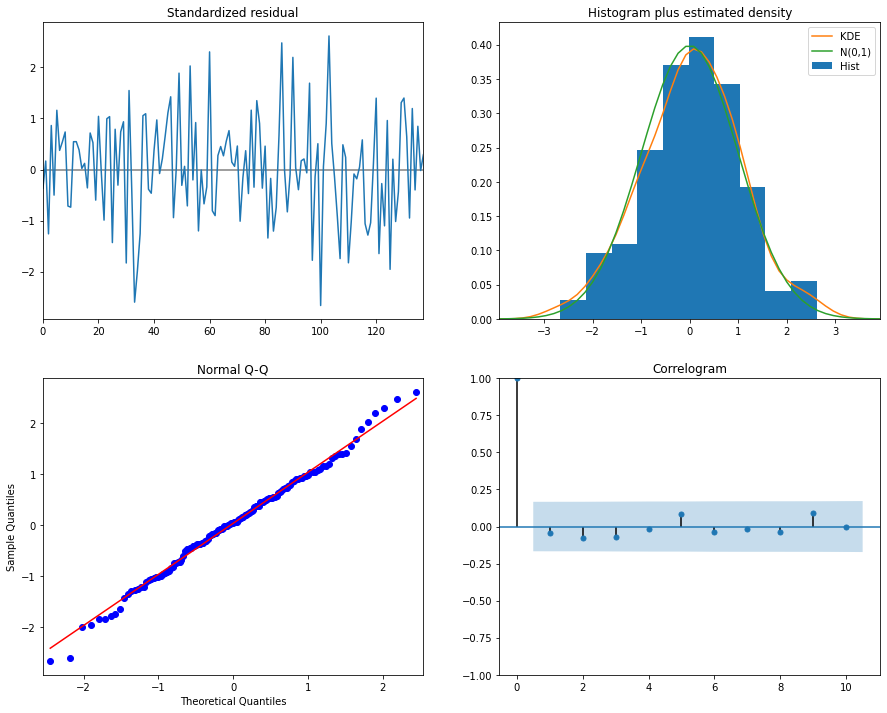

In [50]:
auto_model_diff1.plot_diagnostics(figsize=(15,12))
plt.show()

### **Fitting and Forecast Evaluation**

In [51]:
# Actual vs Fitted
predictions = auto_model_diff1.predict_in_sample()

In [52]:
np.set_printoptions(suppress=True)

In [53]:
forecast = auto_model_diff1.predict(len(data_test), alpha=0.05)  # 95% conf

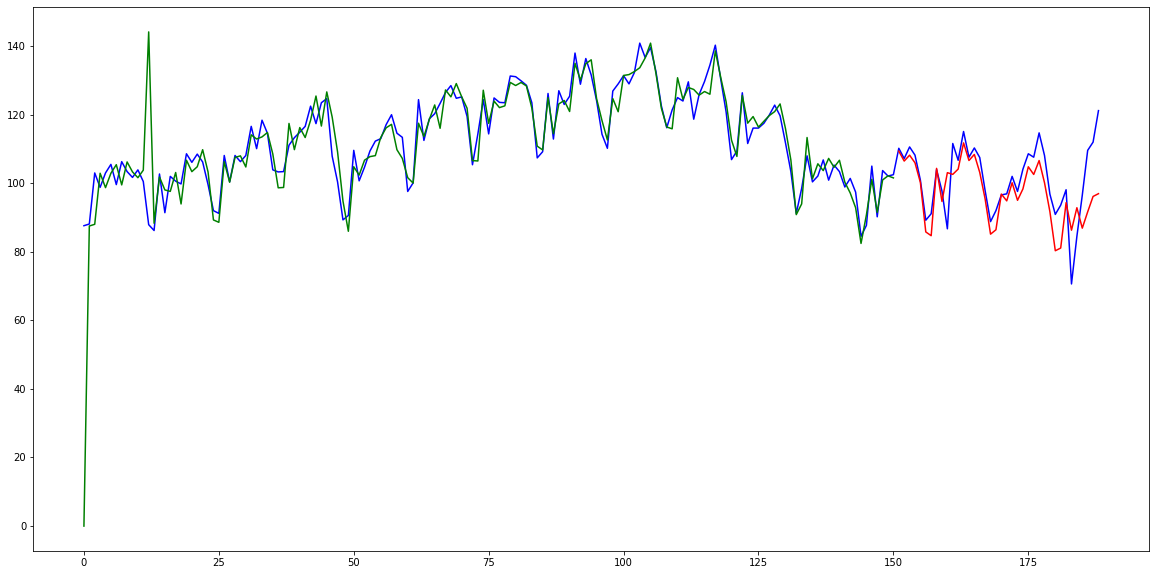

In [54]:
plt.figure(figsize=(20,10))
plt.plot(data.index.values, data.value.values, 'b') # plotting t, b separately 
plt.plot(data_train.index.values, predictions, 'g') # plotting t, c separately 
plt.plot(data_test.index.values, forecast, 'r') # plotting t, c separately 
plt.show()

### **Model Evaluation**

In [55]:
rmse_train = np.mean((data_train[3:].value.values - predictions[3:])**2)**.5  # RMSE TRAIN
rmse_test = np.mean((data_test.value.values - forecast)**2)**.5  # RMSE TEST
print('RMSE Train', rmse_train)
print('RMSE Test', rmse_test)

RMSE Train 5.954460705321384
RMSE Test 8.289538066343514


In [56]:
results = []

In [57]:
results.append(['Model 1 - SARIMAX',
      rmse_train,
      rmse_test
])

## **Model 2 - LSTM (PyTorch)**

### **Target Creation**

In [60]:
# create lagged dataset
lagged_data_train = pd.concat([data_train.value.shift(1), data_train.value], axis=1)
lagged_data_train = pd.concat([data_train[['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features].shift(1), data_train.value_diff1], axis=1)
lagged_data_train.columns = ['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features + ['t+1']

In [61]:
lagged_data_train

,value,value_diff1,value_diff2,month,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,t+1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.6,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,88.1,0.5,NaN,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.9
3,103.0,14.9,14.4,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.2
4,98.8,-4.2,-19.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,87.7,3.2,16.1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.3
147,105.0,17.3,14.1,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.8
148,90.2,-14.8,-32.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.5
149,103.7,13.5,28.3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.6


### **Splitting X and Y datasets**

In [62]:
X_samples = lagged_data_train[3:].drop(['t+1'], axis=1)
Y_samples = lagged_data_train[3:]['t+1']

In [63]:
X_samples

,value,value_diff1,value_diff2,month,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec
3,103.0,14.9,14.4,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,98.8,-4.2,-19.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,103.0,4.2,8.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,105.5,2.5,-1.7,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,99.6,-5.9,-8.4,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,87.7,3.2,16.1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,105.0,17.3,14.1,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,90.2,-14.8,-32.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,103.7,13.5,28.3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
Y_samples

3      -4.2
4       4.2
5       2.5
6      -5.9
7       6.7
       ... 
146    17.3
147   -14.8
148    13.5
149    -1.6
150     0.4
Name: t+1, Length: 148, dtype: float64

### **Tensors Creation**

In [65]:
X_train_tensor = torch.from_numpy(np.array(X_samples)).float().unsqueeze(0)
Y_train_tensor = torch.from_numpy(np.array(Y_samples)).float()

In [66]:
X_train_tensor.shape

torch.Size([1, 148, 17])

In [67]:
Y_train_tensor.shape

torch.Size([148])

### **Model Specification**

In [68]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        hidden_dim = 50
        num_layers = 2
        num_features = 17

        self.lstm = nn.LSTM(num_features, hidden_dim, num_layers)
        
        self.fc_out = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        #x = F.normalize(x)
        x = x.permute(1,0,2)
        #x = x.permute(0,2,1)
        lstm_out, hidden = self.lstm(x)
        #h = self.dropout(lstm_out[-1])
        h = self.dropout(lstm_out)

        # Concatenate in dim1 (feature dimension)

        y = self.fc_out(h)
        return y.squeeze(1).squeeze(1)

In [69]:
criterion = nn.MSELoss()

In [70]:
model = LSTM()

### **Model Training**

In [71]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=0.05)

In [72]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [73]:
for i in range(130):
  model.train()
  optimizer.zero_grad()
  prediction = model(X_train_tensor)
  loss = criterion(prediction, Y_train_tensor)
  loss.backward()
  optimizer.step()

  print(i, float(loss.cpu()))

0 64.07630920410156
1 64.67947387695312
2 64.36795806884766
3 64.33406829833984
4 64.29732513427734
5 64.40861511230469
6 64.00685119628906
7 63.661338806152344
8 63.50038146972656
9 62.5472526550293
10 62.84660720825195
11 61.993019104003906
12 59.8890266418457
13 59.024776458740234
14 59.048431396484375
15 56.697593688964844
16 52.9630241394043
17 54.004905700683594
18 48.8087043762207
19 48.36080551147461
20 45.5573844909668
21 38.25371551513672
22 45.0380744934082
23 44.1440315246582
24 40.497135162353516
25 35.07874298095703
26 41.8144416809082
27 33.85652542114258
28 29.74591827392578
29 32.02626037597656
30 27.53572654724121
31 31.261240005493164
32 23.81718635559082
33 25.45123863220215
34 22.528472900390625
35 28.056974411010742
36 23.805156707763672
37 24.571090698242188
38 20.879314422607422
39 21.19782829284668
40 23.09082794189453
41 20.199424743652344
42 23.410863876342773
43 20.56720542907715
44 20.20218276977539
45 21.12798500061035
46 19.351648330688477
47 19.796241760

### **Model Forecasting**

In [74]:
new_data = data[3:len(data_train)][['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features]

In [75]:
for _ in range(len(data_test)):
  new_X_train_tensor = torch.from_numpy(np.array(new_data.values)).float().unsqueeze(0)
  new_value_diff1 = model(new_X_train_tensor).detach().numpy()[-1]
  new_X_last = new_data[-1:]
  index_row = new_X_last.index[0]
  dict_row = new_X_last.to_dict()
  new_value = dict_row['value'][index_row] + new_value_diff1
  value_diff1 = dict_row['value_diff1'][index_row]
  new_value_diff2 = new_value_diff1 - value_diff1
  new_index_row = index_row + 1

  month_Jul = 1 if (dict_row['month_Jan'][index_row] + dict_row['month_Feb'][index_row] + dict_row['month_Mar'][index_row] + dict_row['month_Apr'][index_row] +
                dict_row['month_May'][index_row] + dict_row['month_Jun'][index_row] + dict_row['month_Aug'][index_row] + dict_row['month_Sep'][index_row] +
                dict_row['month_Oct'][index_row] + dict_row['month_Nov'][index_row] + dict_row['month_Dec'][index_row]) == 0 else 0
  month = dict_row['month'][index_row]

  new_dict_row = {'brazilian_economic_recession': {new_index_row: 0},
  'month': {new_index_row: month + 1 if month < 12 else 1},
  'month_Apr': {new_index_row: dict_row['month_Mar'][index_row]},
  'month_Aug': {new_index_row: month_Jul},
  'month_Dec': {new_index_row: dict_row['month_Nov'][index_row]},
  'month_Feb': {new_index_row: dict_row['month_Jan'][index_row]},
  'month_Jan': {new_index_row: dict_row['month_Dec'][index_row]},
  'month_Jun': {new_index_row: dict_row['month_May'][index_row]},
  'month_Mar': {new_index_row: dict_row['month_Feb'][index_row]},
  'month_May': {new_index_row: dict_row['month_Apr'][index_row]},
  'month_Nov': {new_index_row: dict_row['month_Oct'][index_row]},
  'month_Oct': {new_index_row: dict_row['month_Sep'][index_row]},
  'month_Sep': {new_index_row: dict_row['month_Aug'][index_row]},
  'pandemy_fall': {new_index_row: 0},
  'value': {new_index_row: new_value},
  'value_diff1': {new_index_row: new_value_diff1},
  'value_diff2': {new_index_row: new_value_diff2}}

  new_row = pd.DataFrame(new_dict_row)[['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features]

  new_data = pd.concat([new_data, new_row], axis=0)

### **Fitting and Forecast Evaluation**

In [77]:
prediction_series_values = lagged_data_train[3:].value.values + prediction.detach().numpy()

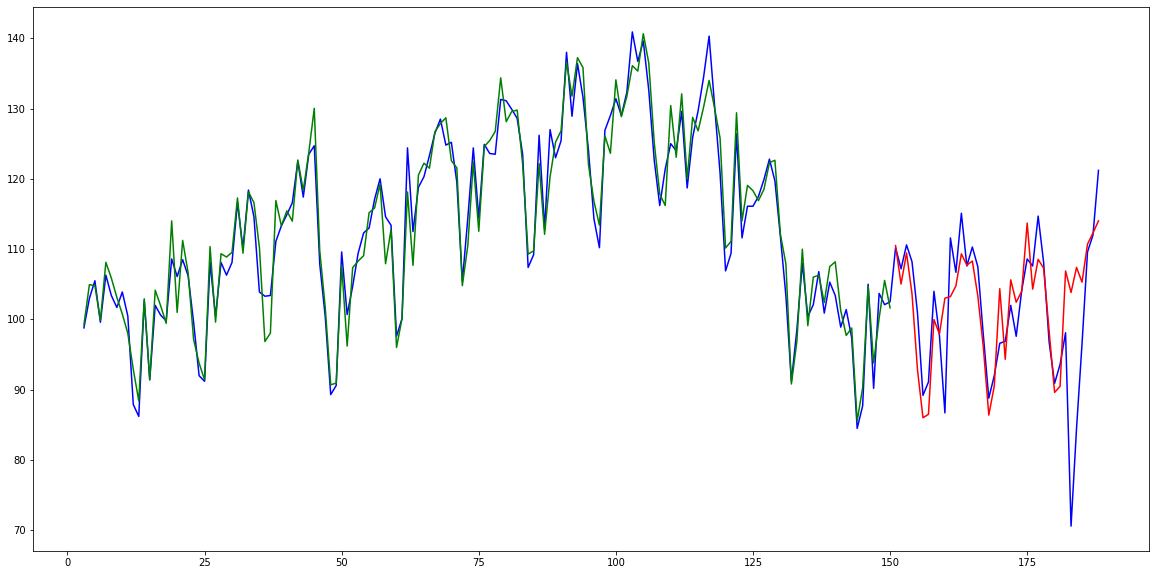

In [78]:
plt.figure(figsize=(20,10))
plt.plot(data[3:].index.values, data[3:].value.values, 'b') # plotting t, b separately 
plt.plot(data_train[3:].index.values, prediction_series_values, 'g') # plotting t, c separately 
plt.plot(new_data[-len(data_test):].index.values, new_data[-len(data_test):].value.values, 'r') # plotting t, c separately
plt.show()

### **Model Evaluation**

In [80]:
rmse_train = np.mean((data_train[3:].value.values - prediction_series_values)**2)**.5  # RMSE TRAIN
rmse_test = np.mean((data_test.value.values - new_data[-len(data_test):].value.values)**2)**.5  # RMSE TEST
print('RMSE Train', rmse_train)
print('RMSE Test', rmse_test)

RMSE Train 2.815343698288922
RMSE Test 8.231829475111297


In [81]:
results.append(['Model 2 - LSTM',
      rmse_train,
      rmse_test
])

# **Final Comparision**

In [82]:
pd.DataFrame(results, columns=['Model', 'AUC Train', 'AUC Test'])

,Model,AUC Train,AUC Test
0,Model 1 - SARIMAX,5.954461,8.289538
1,Model 2 - LSTM,2.815344,8.231829
